In [1]:
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
import numpy as np

import matplotlib.pyplot as plt
import copy

2021-11-18 14:53:32.205963: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0


X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [3]:
total_clusters = len(np.unique(y_test))
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = total_clusters)
# Fitting the model to training set
kmeans.fit(X_train)

MiniBatchKMeans(n_clusters=10)

In [4]:
kmeans.cluster_centers_.shape

(10, 784)

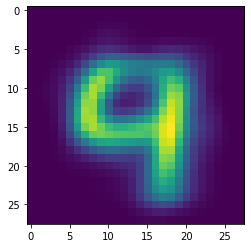

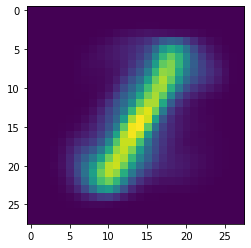

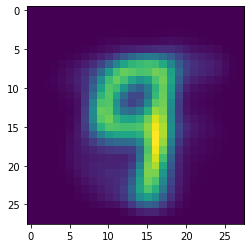

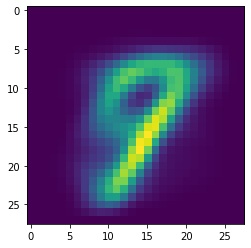

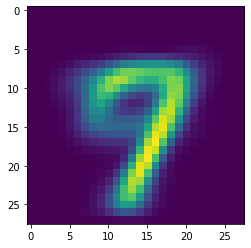

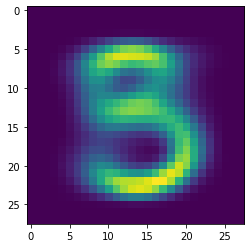

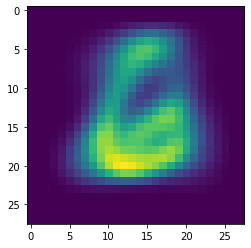

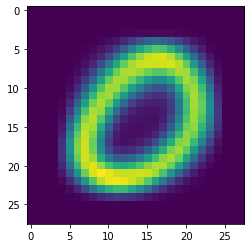

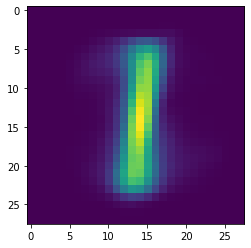

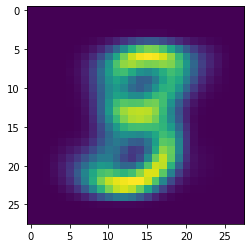

In [5]:
for i in range(10):
    plt.imshow(np.reshape(kmeans.cluster_centers_[i], (28,28)))
    plt.show()

In [6]:
def retrieve_info(cluster_labels,y_train):
    '''
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    '''
    # Initializing
    reference_labels = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(cluster_labels))):
        index = np.where(cluster_labels == i,1,0)
        if index.sum() > 0:
            num = np.bincount(y_train[index==1]).argmax()
            reference_labels[i] = num

    return reference_labels

In [7]:
reference_labels = retrieve_info(kmeans.labels_,y_train)
print(reference_labels)
number_labels = np.random.rand(len(kmeans.labels_))
# Maps labels to indices of kmeans clusters
for i in range(len(kmeans.labels_)):
    # kmeans.labels_[i] is the index of the closest cluster to an image
    # reference_labels gives the most probable actual label of that image
    number_labels[i] = reference_labels[kmeans.labels_[i]]
    
print(accuracy_score(number_labels,y_train))

{0: 4, 1: 1, 2: 9, 3: 7, 4: 7, 5: 3, 6: 6, 7: 0, 8: 1, 9: 3}
0.4900333333333333


In [8]:
def calculate_metrics(model,output):
    print('Number of clusters is {}'.format(model.n_clusters))
    print('Inertia : {}'.format(model.inertia_))
    print('Homogeneity :       {}'.format(metrics.homogeneity_score(output,model.labels_)))

In [9]:
cluster_number = [10,16,36,64,144,256]
for i in cluster_number:
    total_clusters = len(np.unique(y_test))
    # Initialize the K-Means model
    kmeans = MiniBatchKMeans(n_clusters = i)
    # Fitting the model to training set
    kmeans.fit(X_train)

    # Calculating the metrics
    calculate_metrics(kmeans,y_train)
    # Calculating reference_labels
    reference_labels = retrieve_info(kmeans.labels_,y_train)
    # ‘number_labels’ is a list which denotes the number displayed in image
    number_labels = np.random.rand(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
        number_labels[i] = reference_labels[kmeans.labels_[i]]

    print('Accuracy score : {}'.format(accuracy_score(number_labels,y_train)))
    print('\n')

Number of clusters is 10
Inertia : 2388319.0
Homogeneity :       0.5004750893961436
Accuracy score : 0.6278


Number of clusters is 16
Inertia : 2232081.25
Homogeneity :       0.5335108977609764
Accuracy score : 0.6247666666666667


Number of clusters is 36
Inertia : 1958085.625
Homogeneity :       0.688807190472917
Accuracy score : 0.7726333333333333


Number of clusters is 64
Inertia : 1816184.5
Homogeneity :       0.735747429050063
Accuracy score : 0.8070666666666667


Number of clusters is 144
Inertia : 1622253.25
Homogeneity :       0.8096332611862032
Accuracy score : 0.8673333333333333


Number of clusters is 256
Inertia : 1505213.25
Homogeneity :       0.8429586088305664
Accuracy score : 0.8980666666666667




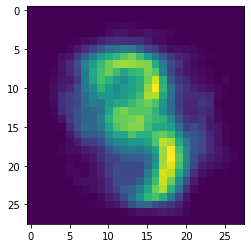

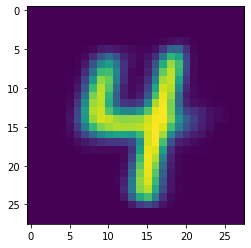

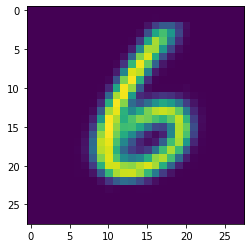

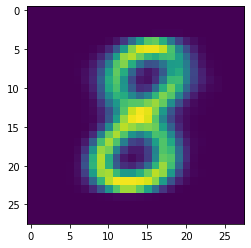

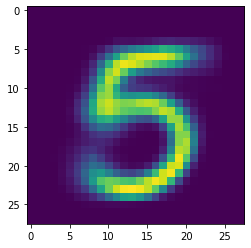

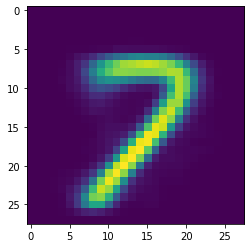

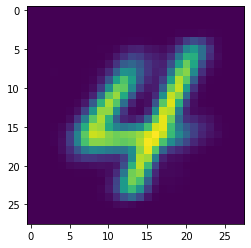

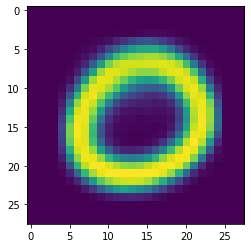

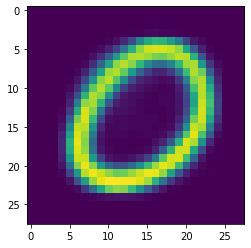

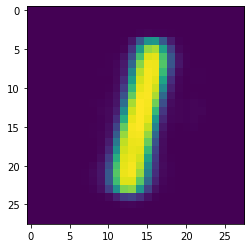

In [10]:
for i in range(10):
    plt.imshow(np.reshape(kmeans.cluster_centers_[i], (28,28)))
    plt.show()

In [39]:
X = X_train[1000:]
Y = y_train[1000:]

In [40]:
random_medians = np.random.rand(10,784)

In [41]:
# k-medians - using l1 norm as objective
# 1 assignment step
#   assign each point to the cluster of the closest 'median' (minimizing objective)
# 2 median step
#   set each 'median' to be the point in its cluster which minimizes the objective for each every point in cluster

medians = random_medians
cluster_assignments = np.zeros((len(X)), dtype=np.uint8)

In [42]:
def median(X, median, iterations=50):
    y = median
    ones = np.ones(X[0].shape, dtype=float)
    for _ in range(iterations):
        num = np.zeros(X[0].shape, dtype=float)
        denom = np.zeros(X[0].shape, dtype=float)
        for i in range(len(X)):
            norm = np.linalg.norm(X[i] - y, ord=1)
            num += np.divide(X[i], norm)
            denom += np.divide(ones, norm)
        y = np.divide(num, denom)
    return y

In [43]:
# Source: https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points
from scipy.spatial.distance import cdist, euclidean
def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

In [44]:
count = 0

# Get initial predictions for randomly generated medians
for i in range(len(X)):
    min_dist = np.inf
    for j in range(len(medians)):
        dist = np.linalg.norm(X[i] - medians[j], ord=1)
        if (dist < min_dist):
            min_dist = dist
            cluster_assignments[i] = j

# Iteratively find median of each cluster, and assign points to nearest cluster
while True:
    start_assignments = copy.deepcopy(cluster_assignments)
    
    for k in range(len(medians)):
        # Get indices of points assigned to this cluster
        indices = np.asarray(cluster_assignments == k).nonzero()[0]
        if len(indices) > 0:
            X_k = X[indices]
            # Find median of this cluster
            #medians[k] = median(X_k, medians[k])
            medians[k] = geometric_median(X_k)
    
    # Assign points to nearest cluster after reassigning medians
    for i in range(len(X)):
        min_dist = np.inf
        for j in range(len(medians)):
            dist = np.linalg.norm(X[i] - medians[j], ord=1)
            if (dist < min_dist):
                min_dist = dist
                cluster_assignments[i] = j
    count += 1
    # If assignments didn't change in this iteration, break out of loop
    if np.where(cluster_assignments == start_assignments, 1, 0).sum() == len(X):
        print(count)
        break

59


In [22]:
def k_medians(X, k=10, medians_init=None):
    # Randomly initialize k medians with the same shape as the first element in X
    if medians_init is None:
        medians = np.random.rand(k,X[0].shape)
    else:
        medians = medians_init
    cluster_assignments = np.zeros((len(X)), dtype=np.uint8)
    num_iterations = 0

    # Get initial predictions for randomly generated medians
    for i in range(len(X)):
        min_dist = np.inf
        for j in range(len(medians)):
            dist = np.linalg.norm(X[i] - medians[j], ord=1)
            if (dist < min_dist):
                min_dist = dist
                cluster_assignments[i] = j

    # Iteratively find median of each cluster, and assign points to nearest cluster
    while True:
        start_assignments = copy.deepcopy(cluster_assignments)

        for k in range(len(medians)):
            # Get indices of points assigned to this cluster
            indices = np.asarray(cluster_assignments == k).nonzero()[0]
            if len(indices) > 0:
                X_k = X[indices]
                # Find median of this cluster
                #medians[k] = median(X_k, medians[k])
                medians[k] = geometric_median(X_k)

        # Assign points to nearest cluster after reassigning medians
        for i in range(len(X)):
            min_dist = np.inf
            for j in range(len(medians)):
                dist = np.linalg.norm(X[i] - medians[j], ord=1)
                if (dist < min_dist):
                    min_dist = dist
                    cluster_assignments[i] = j
        num_iterations += 1
        # If assignments didn't change in this iteration, break out of loop
        if np.where(cluster_assignments == start_assignments, 1, 0).sum() == len(X):
            print(num_iterations)
            break
    
    return medians, cluster_assignments

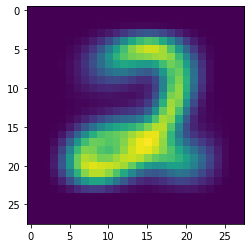

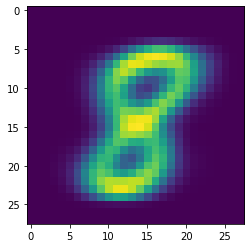

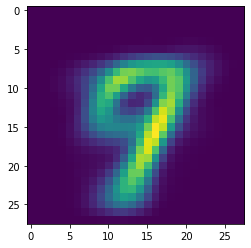

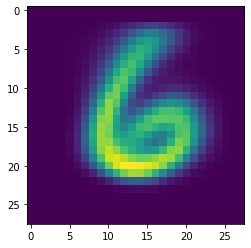

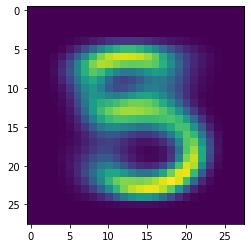

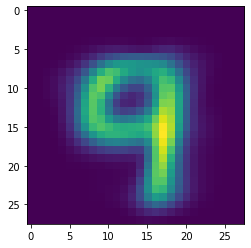

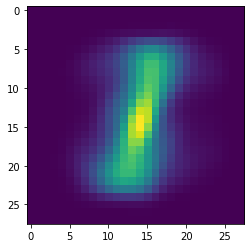

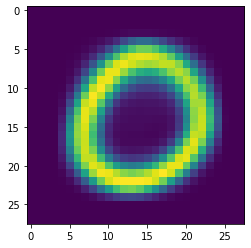

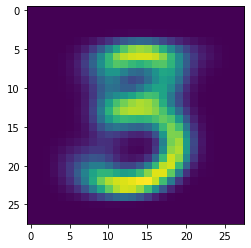

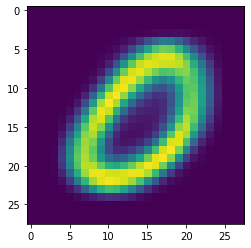

In [47]:
for i in range(10):
    plt.imshow(np.reshape(medians[i], (28,28)))
    plt.show()

In [18]:
reference_labels = retrieve_info(cluster_assignments,Y)
print(reference_labels)
number_labels = np.random.rand(len(cluster_assignments))
# Maps labels to indices of kmeans clusters
for i in range(len(cluster_assignments)):
    number_labels[i] = reference_labels[cluster_assignments[i]]
    
print(accuracy_score(number_labels,Y))

{0: 7, 1: 1, 2: 4, 3: 0, 4: 6, 5: 8, 6: 3, 7: 6, 8: 2, 9: 0}
0.5215833333333333


In [20]:
%time median(X, medians[0])

CPU times: user 33.7 s, sys: 231 µs, total: 33.7 s
Wall time: 33.7 s


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.18210940e-06, 2.96639439e-05, 1.30732151e-05, 5.44717334e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.82420052e-07, 3.29537672e-06, 3.00909995e-05, 7.79460851e-05,
       1.38151142e-04, 2.02886948e-04, 3.96169811e-04, 5.49952568e-04,
       6.14220376e-04, 6.42736298e-04, 6.90807382e-04, 6.52357668e-04,
       7.14213739e-04, 5.89745741e-04, 3.88258376e-04, 2.81807939e-04,
       2.09090813e-04, 7.84966239e-05, 3.81899408e-05, 1.40562605e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [21]:
%time geometric_median(X)

CPU times: user 872 ms, sys: 648 ms, total: 1.52 s
Wall time: 1.52 s


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.17680180e-06, 2.97927074e-05, 1.32294380e-05, 5.51226605e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.77970315e-07, 3.29147623e-06, 3.06001536e-05, 7.93030849e-05,
       1.41095353e-04, 2.07011505e-04, 4.01276891e-04, 5.54153283e-04,
       6.17119601e-04, 6.44276284e-04, 6.92260662e-04, 6.52800791e-04,
       7.15332883e-04, 5.88363826e-04, 3.85312606e-04, 2.80011278e-04,
       2.08343958e-04, 7.85823809e-05, 3.81659393e-05, 1.39534032e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [14]:
train_median = geometric_median(X)

In [45]:
random_medians = np.random.rand(10,784)

eps = .5
non_random_medians = np.zeros((10,784))
for i in range(10):
    non_random_medians[i] = train_median + random_medians[i] * eps

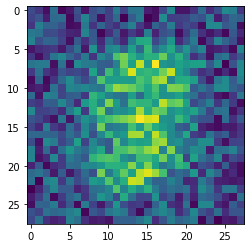

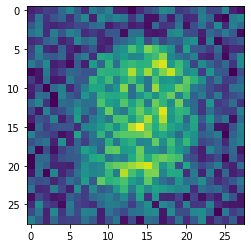

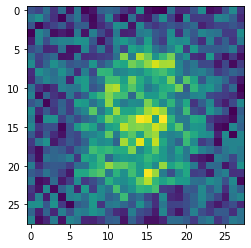

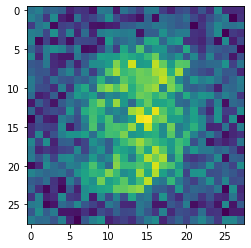

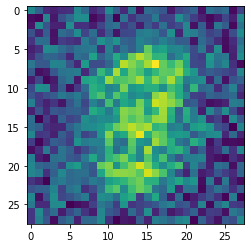

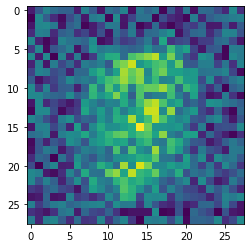

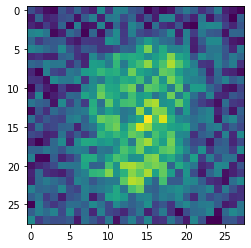

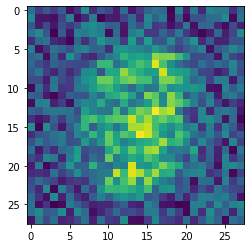

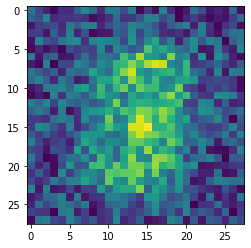

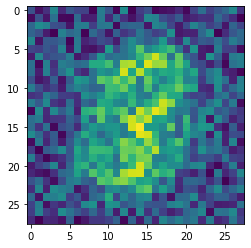

In [46]:
for i in range(10):
    plt.imshow(np.reshape(non_random_medians[i], (28,28)))
    plt.show()

In [48]:
medians, labels = k_medians(X[:1000], 10, non_random_medians)

36


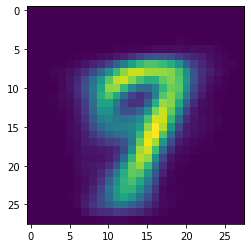

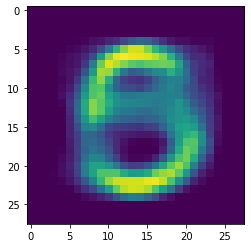

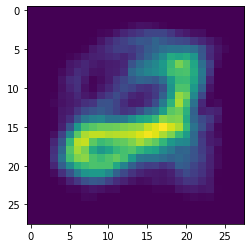

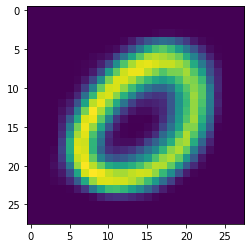

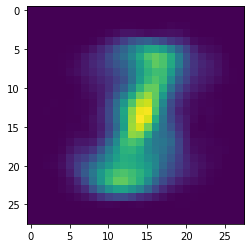

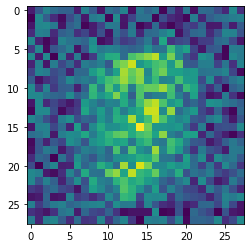

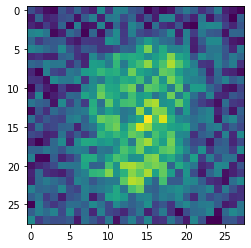

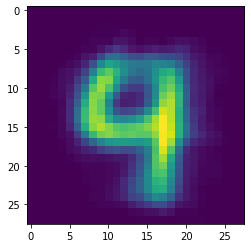

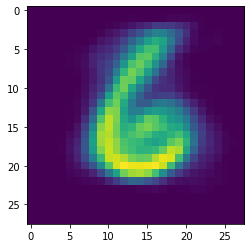

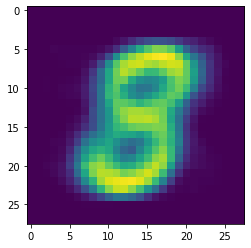

In [49]:
for i in range(len(medians)):
    plt.imshow(np.reshape(medians[i], (28,28)))
    plt.show()